# Tutorial 1: Adding a new equation

If you want to use Trixi for your own research, you might be interested in
a new physics model that's not already included in Trixi.jl. In this tutorial,
we will implement the cubic conservation law
$$
\partial_t u(t,x) + \partial_x u(t,x)^3 = 0
$$
in a periodic domain in one space dimension. In Trixi.jl, such a mathematical model
is encoded as a subtype of [`Trixi.AbstractEquations`](@ref).

## Basic setup

Let's start by creating a module (in the REPL, in a file, in a Jupyter notebook, ...).
That ensures that we can re-create `struct`s defined therein without having to
restart Julia.

In [1]:
module CubicConservationLaw

using Trixi

struct CubicEquation <: Trixi.AbstractEquations{1 #= number of spatial dimensions =#,
                                                1 #= number of primary variables, i.e. scalar =#};
end

end; # module

We create `CubicEquation` as an empty `struct` since we do not use any parameters
for this equation. Other models could bundle arbitrary parameters, e.g., the
ideal gas constant for the compressible Euler equations.

From here on, the following code snippets should be written inside the `module`.
The complete code can be found at the end.
Next, we define the physical flux `f(u) = u^3` using the calling structure
used in Trixi.jl.

In [2]:
using Trixi
import .CubicConservationLaw

Trixi.flux(u, orientation, equation::CubicConservationLaw.CubicEquation) = u.^3
Trixi.varnames(_, ::CubicConservationLaw.CubicEquation) = ("scalar",)

In Trixi.jl, the conserved variables `u` are usually passed as `SVector`s of variables
at a single physical location. Hence, we must use `u.^3` instead of the scalar
operation `u^3`.

That's already enough to run a simple simulation with a standard DGSEM discretization
using the non-dissipative central flux at interfaces. This code is written outside
of our new `module`.

In [3]:
# Create a simulation setup
using OrdinaryDiffEq

equation = CubicConservationLaw.CubicEquation()

initial_condition_sine(x, t, equation::CubicConservationLaw.CubicEquation) = SVector(sinpi(x[1]))

mesh = TreeMesh(-1.0, 1.0, # min/max coordinates
                initial_refinement_level=4,
                n_cells_max=10^4)

solver = DGSEM(3 #= polynomial degree =#, flux_central)

semi = SemidiscretizationHyperbolic(mesh, equation, initial_condition_sine, solver)

# Create ODE problem with given time span
tspan = (0.0, 0.09)
ode = semidiscretize(semi, tspan);

We wrap the return value of the `initial_condition_sine` inside an `SVector` since that's the approach
used in Trixi.jl also for systems of equations. We need to index the spatial coordinate `x[1]`,
since it is an `SVector` with one component. In multiple space dimensions, all spatial coordinates
are passed together.

The `ode` is an `ODEProblem` from the SciML/DifferentialEquations ecosystem.
Thus, we can solve this ODE numerically using any time integration method,
e.g., `SSPRK43` from [OrdinaryDiffEq.jl](https://github.com/SciML/OrdinaryDiffEq.jl).
Before, we set up a [callback](@ref callbacks-id) to summarize the simulation setup.

In [4]:
summary_callback = SummaryCallback()
callbacks = CallbackSet(summary_callback)

# OrdinaryDiffEq's `solve` method evolves the solution in time and executes the passed callbacks
sol = solve(ode, SSPRK43(),
            save_everystep=false, callback=callbacks, maxiters=1e5);

# Print the timer summary
summary_callback()


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 31                  │
│ equations: …………………………………………………… CubicEquation                                                    │
│ initial condition: ……………………………… initial_condition_sine                                           │
│ boundary conditions: ………………………… 2                                                                

That's it, you ran your first simulation using your new equation with Trixi! Now,
we can plot the solution at the final time using Plots.jl.

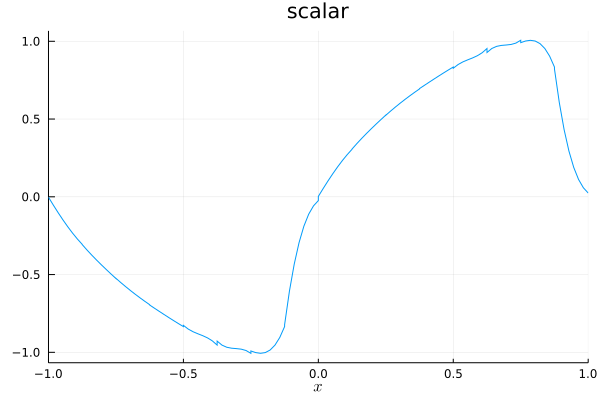

In [5]:
using Plots
plot(sol)

You can already see that discontinuities will develop and oscillations start to
occur around steep parts of the wave. That's expected from our central discretization.
To avoid these issues, we need to use dissipative numerical fluxes (approximate
Riemann solvers) at interfaces.

## Advanced setup

Thus, we add a Godunov's flux for our cubic equation. That is easy for this equation
since the wave speed `f'(u) = 3u^2` is always non-negative.

In [6]:
@inline Trixi.flux_godunov(u_ll, u_rr, orientation, equation::CubicConservationLaw.CubicEquation) = flux(u_ll, orientation, equation)

Let's run the example again but with a dissipative numerical flux at interfaces.
`remake` will recreate the semidiscretization we used before and only change
selected parameters, in this case the `solver`.


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 31                  │
│ equations: …………………………………………………… CubicEquation                                                    │
│ initial condition: ……………………………… initial_condition_sine                                           │
│ boundary conditions: ………………………… 2                                                                

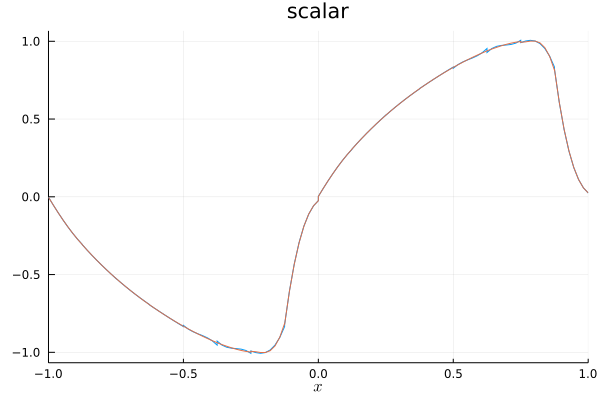

In [7]:
# A new setup with dissipation
semi = remake(semi, solver=DGSEM(3, flux_godunov))
ode = semidiscretize(semi, tspan)
sol = solve(ode, SSPRK43(),
            save_everystep=false, callback=callbacks, maxiters=1e5);
summary_callback()
plot!(sol)

You can see that there are fewer oscillations, in particular around steep edges.
Now let's increase the final time (and also the spatial resolution).


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 511                 │
│ equations: …………………………………………………… CubicEquation                                                    │
│ initial condition: ……………………………… initial_condition_sine                                           │
│ boundary conditions: ………………………… 2                                                                

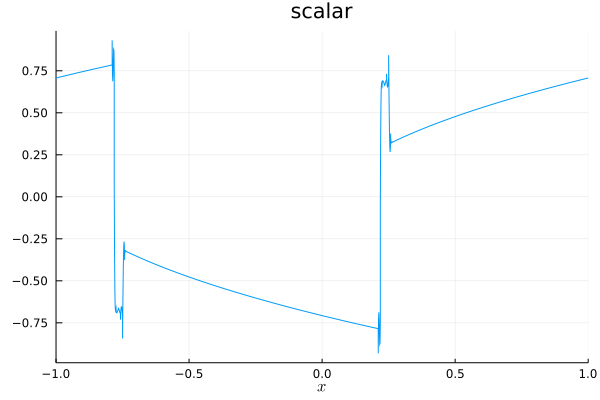

In [8]:
# A larger final time: Nonclassical shocks develop (you can even increase the refinement to 12)
semi = remake(semi, mesh=TreeMesh(-1.0, 1.0, initial_refinement_level=8, n_cells_max=10^5))
ode = semidiscretize(semi, (0.0, 0.5))
sol = solve(ode, SSPRK43(),
            save_everystep=false, callback=callbacks, maxiters=1e5);
plot(sol)

You can observe that nonclassical shocks develop and are stable under grid refinement,
e.g. for `initial_refinement_level=12`. In this case, these nonclassical shocks
can be avoided by using an entropy-dissipative semidiscretization. Thus, we need
to define an entropy-conservative numerical flux

In [9]:
@inline function Trixi.flux_ec(u_ll, u_rr, orientation, equation::CubicConservationLaw.CubicEquation)
  return SVector(0.25 * (u_ll[1]^3 + u_ll[1]^2 * u_rr[1] + u_ll[1] * u_rr[1]^2 + u_rr[1]^3))
end

and use a [`VolumeIntegralFluxDifferencing`](@ref) instead of the standard
[`VolumeIntegralWeakForm`](@ref) in the DGSEM.


████████╗██████╗ ██╗██╗  ██╗██╗
╚══██╔══╝██╔══██╗██║╚██╗██╔╝██║
   ██║   ██████╔╝██║ ╚███╔╝ ██║
   ██║   ██╔══██╗██║ ██╔██╗ ██║
   ██║   ██║  ██║██║██╔╝ ██╗██║
   ╚═╝   ╚═╝  ╚═╝╚═╝╚═╝  ╚═╝╚═╝

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 511                 │
│ equations: …………………………………………………… CubicEquation                                                    │
│ initial condition: ……………………………… initial_condition_sine                                           │
│ boundary conditions: ………………………… 2                                                                

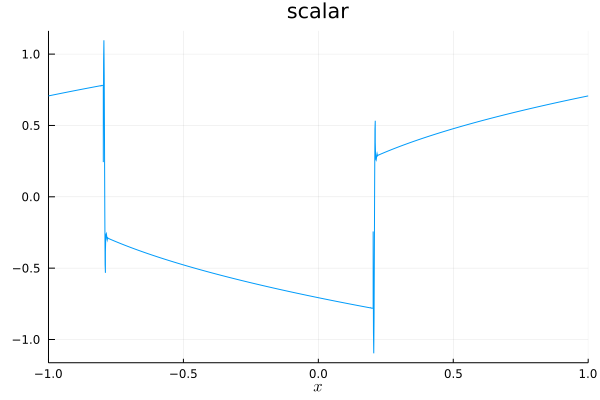

In [10]:
# Let's use a provably entropy-dissipative semidiscretization
semi = remake(semi, solver=DGSEM(3, flux_godunov, VolumeIntegralFluxDifferencing(flux_ec)))
ode = semidiscretize(semi, (0.0, 0.5))
sol = solve(ode, SSPRK43(),
            save_everystep=false, callback=callbacks, maxiters=1e5);
plot(sol)

Possible next steps could be
- to define `Trixi.max_abs_speeds(u, equations::CubicEquation) = 3 * u[1]^2`
  to use CFL_based time step control via a [`StepsizeCallback`][@ref]
- to define quantities of interest like `Trixi.entropy(u, equations::CubicEquation) = u[1]^2`
  and integrate them in a simulation using the [`AnalysisCallback`](@ref)
- to experiment with shock-capturing volume integrals [`VolumeIntegralShockCapturingHG`](@ref)
  and adaptive mesh refinement [`AMRCallback`](@ref)

## Summary of the code

To sum up, here is the complete code that we used (without the [`SummaryCallback`](@ref)
since that creates a lot of unnecessary output in the doctests of this tutorial).

In [11]:
# Define new physics
module CubicConservationLaw

  using Trixi

  struct CubicEquation <: Trixi.AbstractEquations{1 #= number of spatial dimensions =#,
                                                  1 #= number of primary variables, i.e. scalar =#}
  end

  @inline Trixi.flux(u, orientation, equation::CubicEquation) = u.^3
  Trixi.varnames(_, ::CubicEquation) = ("scalar",)

  @inline Trixi.flux_godunov(u_ll, u_rr, orientation, equation::CubicEquation) = flux(u_ll, orientation, equation)
  @inline function Trixi.flux_ec(u_ll, u_rr, orientation, equation::CubicEquation)
    return SVector(0.25 * (u_ll[1]^3 + u_ll[1]^2 * u_rr[1] + u_ll[1] * u_rr[1]^2 + u_rr[1]^3))
  end

end # module


# Create a simulation setup
import .CubicConservationLaw
using Trixi
using OrdinaryDiffEq
using Plots

equation = CubicConservationLaw.CubicEquation()

initial_condition_sine(x, t, equation::CubicConservationLaw.CubicEquation) = SVector(sinpi(x[1]))

mesh = mesh = TreeMesh(-1.0, 1.0, # min/max coordinates
                       initial_refinement_level=4,
                       n_cells_max=10^4)

solver = DGSEM(3 #= polynomial degree =#, flux_central)

semi = SemidiscretizationHyperbolic(mesh, equation, initial_condition_sine, solver)

# Create ODE problem with given time span
tspan = (0.0, 0.1)
ode = semidiscretize(semi, tspan)

# OrdinaryDiffEq's `solve` method evolves the solution in time and executes the passed callbacks
sol = solve(ode, SSPRK43(), save_everystep=false);
plot(sol);


# A new setup with dissipation
semi = remake(semi, solver=DGSEM(3, flux_godunov))
ode = semidiscretize(semi, tspan)
sol = solve(ode, SSPRK43(), save_everystep=false);
plot!(sol);


# A larger final time: Nonclassical shocks develop (you can even increase the refinement to 12)
semi = remake(semi, mesh=TreeMesh(-1.0, 1.0, initial_refinement_level=8, n_cells_max=10^5))
ode = semidiscretize(semi, (0.0, 0.5))
sol = solve(ode, SSPRK43(), save_everystep=false);
plot(sol);


# Let's use a provably entropy-dissipative semidiscretization
semi = remake(semi, solver=DGSEM(3, flux_godunov, VolumeIntegralFluxDifferencing(flux_ec)))
ode = semidiscretize(semi, (0.0, 0.5))
sol = solve(ode, SSPRK43(), save_everystep=false);
plot(sol);

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*